In [ ]:
## work on a small slice initially 

In [1]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from numpy import moveaxis
from IPython.display import clear_output
import matplotlib.pyplot as plt
# import pandas as pd
import shutil
plt.rcParams["figure.figsize"] = (10,10)

In [5]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [23]:

source_path = "work_data/video/c_elegans_movement.mp4"
target_path = "work_data/trimmed/first_five_seconds.mp4"

trim_video(
    source_path = source_path, 
    start_time = 10, 
    end_time = 16, 
    target_path = target_path)

In [24]:
def video_to_frames(video_path, new_folder_path):
    
    frames_paths = []
    
    try:
        os.mkdir(new_folder_path)
    except:
        shutil.rmtree(new_folder_path)
        os.mkdir(new_folder_path)

        
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)
    
    return frames_paths

In [25]:
frames_folder = "work_data/trimmed/frames"
frames_paths = video_to_frames(
                                video_path = target_path,
                                new_folder_path = frames_folder
                               )

saved  181  frames at  work_data/trimmed/frames


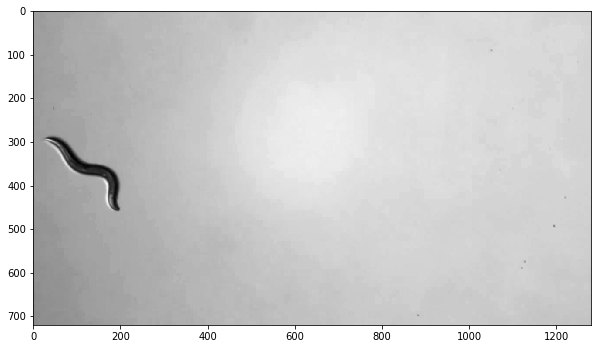

(720, 1280)


In [146]:
sample_image = cv2.imread(frames_folder+ "/" + "1.jpg", 0)
plt.imshow(sample_image, cmap = "gray")
plt.show()
print(sample_image.shape)

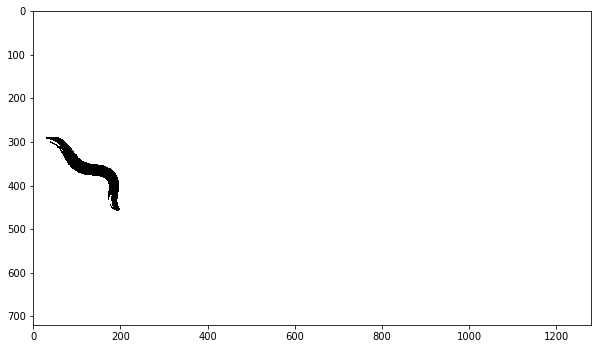

In [147]:
ret,thresh1 = cv2.threshold(sample_image,80, 255,cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap = "gray")
plt.show()

(240, 426)


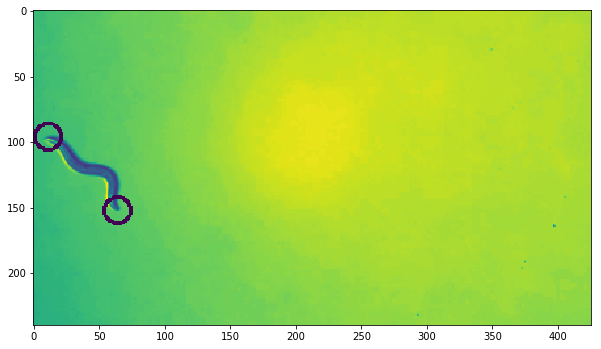

In [148]:
thresh1_small = cv2.resize(thresh1, (int(thresh1.shape[1]/3), int(thresh1.shape[0]/3)))
sample_image_small = cv2.resize(sample_image, (int(thresh1.shape[1]/3), int(thresh1.shape[0]/3)))

print(thresh1_small.shape)

vertices = []

for i in range(thresh1_small.shape[0]):
    for j in range (thresh1_small.shape[1]):
        if thresh1_small[i][j] < 50:
            vertices.append((j,i))
            break
    else:
        continue
    break
    

for i in range(thresh1_small.shape[0]-1, 0, -1):
    for j in range (thresh1_small.shape[1]-1, 0, -1):
        if thresh1_small[i][j] < 20:
            vertices.append((j,i))
            break
    else:
        continue
    break
    
for m in vertices:
    frame = cv2.circle(sample_image_small, 
                       m, 
                       radius = 10, 
                       color = (0, 100, 255) , 
                       thickness = 2)
    
plt.imshow(sample_image_small)
plt.show()

In [67]:
def find_worm_and_return_circle_locations(thresh_image_np_array, upper_thresh):
    
    vertices = []

    for i in range(thresh_image_np_array.shape[0]):  ## look for end 1
        for j in range (thresh_image_np_array.shape[1]):
            if thresh_image_np_array[i][j] < upper_thresh:
                vertices.append((j,i))
                break
        else:
            continue
        break


    for i in range(thresh_image_np_array.shape[0]-1, 0, -1):   ## look for end 2 
        for j in range (thresh_image_np_array.shape[1]-1, 0, -1):
            if thresh_image_np_array[i][j] < upper_thresh:
                vertices.append((j,i))
                break
        else:
            continue
        break
    
    return vertices

def threshold_image_np(raw_img, upper_gray_threshold):  ## converts all pixels above upper_gray_threshold to 255 = white 
    
    ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY)
    return thresh1
    
def read_and_shrink_image(image_path, shrink_factor = 2):
    raw_img = cv2.imread(image_path, 0) ## 0 means grayscale = 1 color channel 
    raw_img_small = cv2.resize(raw_img, (int(raw_img.shape[1]/shrink_factor), int(raw_img.shape[0]/shrink_factor)))
    return raw_img_small

def draw_circle(image, vertex, radius):
    
    with_circle = cv2.circle(
                            image,                
                            vertex, 
                            radius = radius, 
                            color = (0, 100, 255) , 
                            thickness = 2)
    return with_circle

def draw_rectangle(image, vertex1, vertex2):
    image = cv2.rectangle(image,
                    vertex1,
                    vertex2,
                    color=(0, 255, 0), thickness=3)
    return image


In [68]:
circles_save_folder = "work_data/trimmed/circles"

try:
    os.mkdir(circles_save_folder)
except:
    shutil.rmtree(circles_save_folder)
    os.mkdir(circles_save_folder)

imcount = 0
for i in tqdm(frames_paths):
    
    
    image_path = i
    save_name = circles_save_folder + "/"+ str(imcount) + ".jpg"
    
    try:
        raw_img_small = read_and_shrink_image(image_path, shrink_factor = 4)
        raw_img_small = cv2.blur(raw_img_small,(3,3)) 
    except:
        continue
         
    thresh = threshold_image_np(raw_img_small, upper_gray_threshold = 70)
    
    vertices = find_worm_and_return_circle_locations(thresh, upper_thresh = 70)
    
    raw_img_small = draw_rectangle(raw_img_small, vertices[0], vertices[1])
        
    raw_img_color = cv2.applyColorMap( raw_img_small , colormap = cv2.COLORMAP_JET)
        
    cv2.imwrite( save_name, raw_img_color)
    
    imcount += 1
    
    

    

In [71]:
circled_save_paths = [circles_save_folder + "/" + str(i) + ".jpg" for i in range (imcount)]
# circled_save_paths

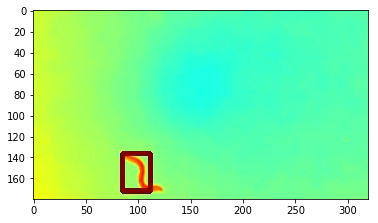

In [72]:
for i in circled_save_paths:
    im = cv2.imread(i)
    plt.imshow(im)
    plt.show()
    clear_output(wait = True)

In [70]:
from moviepy.editor import *
clips = [ImageClip(m).set_duration(0.02)
      for m in  circled_save_paths]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("test_worm_track.mp4", fps=60)

t:  30%|██▉       | 65/218 [00:00<00:00, 643.26it/s, now=None]

Moviepy - Building video test_worm_track.mp4.
Moviepy - Writing video test_worm_track.mp4



Moviepy - Done !
Moviepy - video ready test_worm_track.mp4
